In [2]:
# let's handle imports first.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import networkx as nx
import scipy.stats

warnings.filterwarnings("ignore")

# Automated formatter.
import jupyter_black

jupyter_black.load()

# Introduction
Welcome to my Music League analysis! I decided to do this for fun because I thought the dataset was rich and it would be interesting to see the music preferences and relationships from within our group. I also found the final analytics insight from the app a little lackluster so I thought people would want to see a more in-depth view of how they did.

Disclaimer: Analyses here are for-funsies only, and not subject to academic levels of rigor. 

# Methodology
I manually entered the data from the Music League website (too lazy to build a scraper). I organized it into 3 hierarchical categories:
1. Round data -- simply metadata about the round number and the prompt.
2. Submission data -- data on the song name and the submitting player.
3. Results data -- voting patterns for each round.

For the submission data, I also leveraged the [Spotify API](https://developer.spotify.com/documentation/web-api) to acquire external data about individual songs. Using [spotipy](https://spotipy.readthedocs.io/en/2.24.0/), I made calls to find:
1. The artist's "popularity". Spotify's [documentation](https://developer.spotify.com/documentation/web-api/reference/get-an-artist) is not very thorough about the specifics of how this metric was calculated, but seems to suggest that it's an aggregate of the play count of all the artist's tracks, weighted by the recency of the plays and ranges from 0-100.
2. The artist's genres.

After a one-time batch call, I joined these results to the original `submissions` table and saved it as a `csv`. Truncated views of these tables are displayed below. 

## Read data

In [3]:
submissions = pd.read_csv("../data/round_submissions.csv")
rounds = pd.read_csv("../data/rounds.csv")
results = pd.read_csv("../data/round_results.csv")

# Join the results to submissions to get Spotify's popularity and genre data.
results = results.merge(
    submissions.drop(columns=["song_name"]),
    how="left",
    on=["round_number", "submitter_name", "league_title"],
)

# An artist can have multiple genres, so take only the first one.
# Not sure if this is considered the artist's "primary" genre.
for df in [results, submissions]:
    df["genres"] = df["genres"].apply(lambda x: x[1:-1].split(","))
    df["primary_genre"] = df["genres"].apply(lambda x: x[0])

### Round data
Simply the round number and round name. 

In [4]:
rounds

,league_title,league_number,round_name,round_description,round_number
0,BOS BOPS,1,Earworms,Songs you can't get out of your head.,1
1,BOS BOPS,1,Disney,Give us those movie tunes!,2
2,BOS BOPS,1,Fall,Songs that make you think of fall.,3
3,BOS BOPS,1,Unromantic,Songs to avoid at a wedding.,4
4,BOS BOPS,1,Pump Me Up,Great songs for a workout playlist.,5
5,BOS BOPS,1,Covers,Songs previously recorded by another artist.,6
6,BOS BOPS,1,Holiday Szn,Favorite winter holiday song! 🎅 🕎 🌲 🥶,7
7,BOS BOPS,1,Awesome Obscurity,Songs that aren't well-known but should be.,8
8,BOS BOPS,1,"Thanks, Mom and Dad",Songs that your parents listened to when you w...,9
9,BOS BOPS,1,Can I Have A Word?,Songs with one word titles.,10


### Submission data
Data on the submitting players and their songs, plus data augmented by the Spotify API -- artist popularity and genres. 

In [5]:
submissions

,league_title,round_number,submitter_name,song_name,song_artist,song_album,rank,submitter_comments,voted,genres,artist_popularity,primary_genre
0,BOS BOPS,1,Sean Wong,Lil Boo Thang,Paul Russell,Lil Boo Thang,1,NaN,True,['indie r&b'],63,'indie r&b'
1,BOS BOPS,1,Donna Koo,Seven (feat. Latto),Jung Kook,Seven (feat. Latto),2,NaN,True,['k-pop'],83,'k-pop'
2,BOS BOPS,1,Chris Podracky,vampire,Olivia Rodrigo,GUTS,3,Playing a DND campaign where the main villain ...,True,['pop'],86,'pop'
3,BOS BOPS,1,Richard Hill,Paint The Town Red,Doja Cat,Paint The Town Red,4,NaN,True,"['dance pop', 'pop']",84,'dance pop'
4,BOS BOPS,1,Tammy Liaw,24K Magic,Bruno Mars,24K Magic,5,NaN,True,"['dance pop', 'pop']",86,'dance pop'
...,...,...,...,...,...,...,...,...,...,...,...,...
134,BOS BOPS,11,Richard Hill,Blue Ridge Mountains,Fleet Foxes,Fleet Foxes,8,NaN,True,"['chamber pop', 'folk', 'indie folk', 'indi...",60,'chamber pop'
135,BOS BOPS,11,Jackie Wu,The Sixth Station,Joe Hisaishi,Spirited Away Soundtrack,9,We could all use some tea time with Zeniba.,True,"['anime', 'anime score', 'japanese classical...",67,'anime'
136,BOS BOPS,11,Chris Podracky,"4th of July, Asbury Park (Sandy)",Bruce Springsteen,"The Wild, the Innocent & The E Street Shuffle",10,A date and a place so you know exactly where y...,True,"['heartland rock', 'mellow gold', 'permanent...",73,'heartland rock'
137,BOS BOPS,11,Michelle Wang,Closer,The Chainsmokers,Closer,11,I know this doesn’t actually fit the rules but...,True,['pop'],79,'pop'


### Voting data
How everyone voted each round.

In [6]:
results

,league_title,round_number,submitter_name,song_name,voter_name,vote_value,voter_comment,song_artist,song_album,rank,submitter_comments,voted,genres,artist_popularity,primary_genre
0,BOS BOPS,1,Sean Wong,Lil Boo Thang,Jen Tsang,2,NaN,Paul Russell,Lil Boo Thang,1,NaN,True,['indie r&b'],63,'indie r&b'
1,BOS BOPS,1,Sean Wong,Lil Boo Thang,Jenni Podracky,2,NaN,Paul Russell,Lil Boo Thang,1,NaN,True,['indie r&b'],63,'indie r&b'
2,BOS BOPS,1,Sean Wong,Lil Boo Thang,Richard Hill,1,"Fun song, new artist to me :)",Paul Russell,Lil Boo Thang,1,NaN,True,['indie r&b'],63,'indie r&b'
3,BOS BOPS,1,Sean Wong,Lil Boo Thang,Donna Koo,1,NaN,Paul Russell,Lil Boo Thang,1,NaN,True,['indie r&b'],63,'indie r&b'
4,BOS BOPS,1,Sean Wong,Lil Boo Thang,June Wang,1,NaN,Paul Russell,Lil Boo Thang,1,NaN,True,['indie r&b'],63,'indie r&b'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,BOS BOPS,11,Jen Tsang,Havana (feat. Young Thug),Chris Podracky,1,NaN,Camila Cabello,Camila,12,NaN,False,"['dance pop', 'pop']",78,'dance pop'
902,BOS BOPS,11,Jen Tsang,Havana (feat. Young Thug),June Wang,1,NaN,Camila Cabello,Camila,12,NaN,False,"['dance pop', 'pop']",78,'dance pop'
903,BOS BOPS,11,Jen Tsang,Havana (feat. Young Thug),Alex Chao,1,NaN,Camila Cabello,Camila,12,NaN,False,"['dance pop', 'pop']",78,'dance pop'
904,BOS BOPS,11,Jen Tsang,Havana (feat. Young Thug),Tammy Liaw,1,NaN,Camila Cabello,Camila,12,NaN,False,"['dance pop', 'pop']",78,'dance pop'


# Results

## Part I. Player and song performance
### Points every round
This shows your progress over each round. Not many exciting insights here other than:
- **Jackie** was on track to come in 3rd but got owned in the final 2 rounds to let **Mui** overtake her.
- **Anna** quit after Awesome Obscurity for some reason.
- **Jen** was on track to top 3 before suffering a string of missed voting that accumulated downvotes bringing her to 8th. (Did you know: Not voting means you lose all your upvotes but downvotes still take effect)

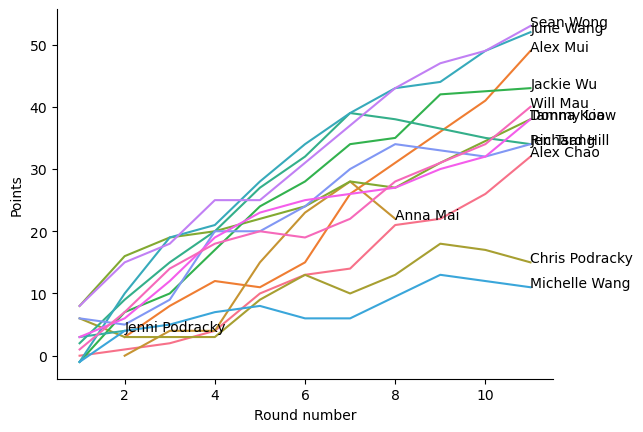

In [41]:
points = (
    results.query("voted | (~voted & vote_value < 0)")
    .groupby(["submitter_name", "round_number"])["vote_value"]
    .sum()
    .groupby(level=0)
    .cumsum()
    .reset_index()
    .rename(columns={"vote_value": "points"})
)
final_score = points.groupby("submitter_name").last()

fig, ax = plt.subplots()

sns.lineplot(
    data=points, x="round_number", y="points", hue="submitter_name", legend=False, ax=ax
)

for i, player in final_score.iterrows():
    ax.annotate(player.name, (player["round_number"], player["points"]))
[ax.spines[side].set_visible(False) for side in ["top", "right"]]
ax.set_xlabel("Round number")
_ = ax.set_ylabel("Points")

### Number of podium finishes
This plot shows the number of top 3 finishes each round. 
- **June** was the most decorated player, with three 1st places, one 2nd, and one 3rd.
- **Mui** was the second most decorated player, with three 1st places (tied with **June**), and one 3rd place. 

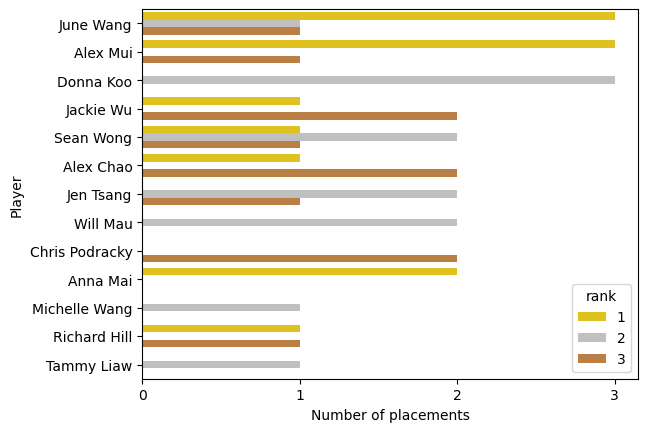

In [40]:
podium_finishes = (
    submissions.groupby(["submitter_name", "rank"])["round_number"]
    .count()
    .reset_index()
    .rename(columns={"round_number": "placements"})
    .query("rank <= 3")
    .sort_values("placements", ascending=False)
)

colors = ["#FFD700", "#C0C0C0", "#CD7F32"]
podium_palette = sns.color_palette(colors)

fig, ax = plt.subplots()

sns.barplot(
    data=podium_finishes,
    y="submitter_name",
    x="placements",
    hue="rank",
    palette=podium_palette,
    ax=ax,
)
ax.set_xticks(range(4))
ax.set_xlabel("Number of placements")
_ = ax.set_ylabel("Player")

### Song performances
I always enjoyed Spotify Wrapped. Here's kind of the Music League version. How did each song do individually? Below, let's aggregate the vote totals for each song and sort them.

In [9]:
# Aggregate by song.
song_totals = (
    results.query("vote_value != 0")
    .groupby(["round_number", "submitter_name", "song_name"])
    .agg(
        vote_value=("vote_value", "sum"),
        upvote_total=("vote_value", lambda x: x[x > 0].sum()),
        downvote_total=("vote_value", lambda x: x[x < 0].sum()),
    )
    .sort_values("vote_value", ascending=False)
    .reset_index()
)

song_totals["song_and_submitter"] = (
    song_totals["submitter_name"] + ": " + song_totals["song_name"]
)

## Top 10 songs
Top songs with 11 votes each: 
1. **Richard**: Unholy Matrimony
2. **June**: You'll Be In My Heart
3. **Mui**: Underneath the Tree
4. **Anna**: INDUSTRY BABY

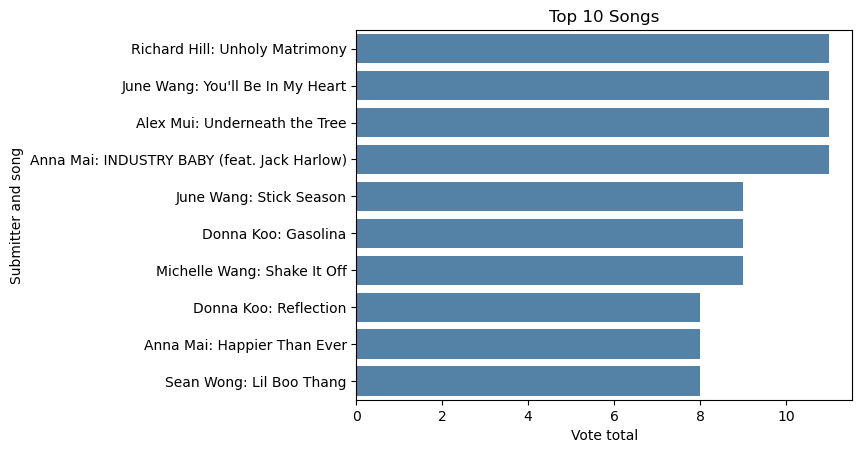

In [39]:
fig, ax = plt.subplots()

sns.barplot(
    data=song_totals.iloc[:10],
    x="vote_value",
    y="song_and_submitter",
    color="steelblue",
    ax=ax,
)
ax.set_title("Top 10 Songs")
ax.set_xlabel("Vote total")
_ = ax.set_ylabel("Submitter and song")

### Bottom 10 songs
Most hated song was Magic Shop submitted by **Anna**. We all know why. 

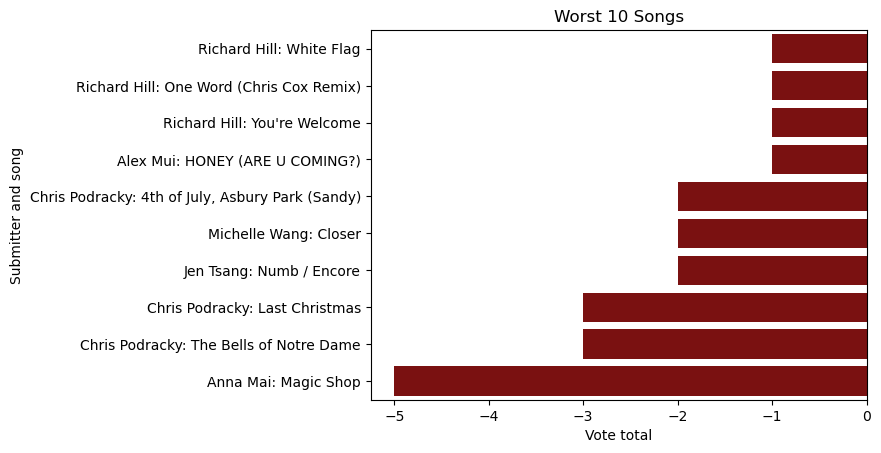

In [38]:
fig, ax = plt.subplots()

sns.barplot(
    data=song_totals.iloc[-10:],
    x="vote_value",
    y="song_and_submitter",
    color="darkred",
    ax=ax,
)
ax.set_title("Worst 10 Songs")
ax.set_xlabel("Vote total")
_ = ax.set_ylabel("Submitter and song")

### Most polarizing songs
These are songs with a high number of both upvotes and downvotes. The winner was Closer (Nine Inch Nails) submitted by **Chris** which had +5 and -5, with a final score of 0. 

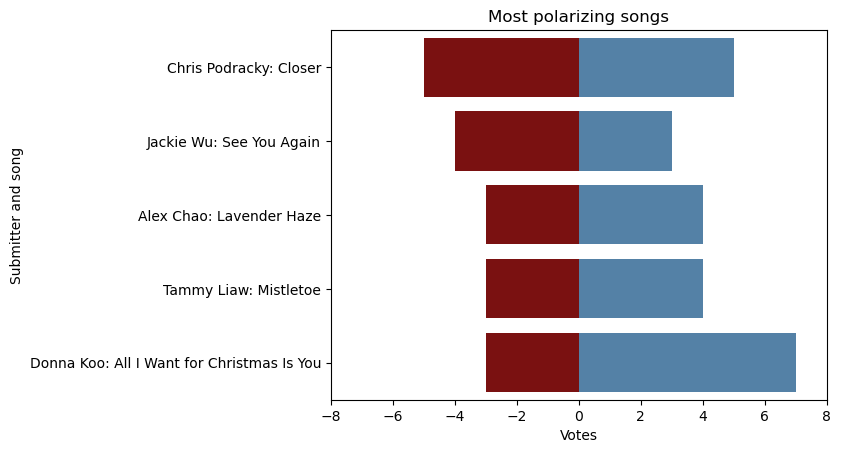

In [37]:
song_totals["diff"] = song_totals["upvote_total"] + abs(song_totals["downvote_total"])
song_totals["abs_vote_value"] = abs(song_totals["vote_value"])
contentious = song_totals.query("upvote_total > 2 & downvote_total < -2").sort_values(
    ["abs_vote_value", "diff", "downvote_total"], ascending=[True, False, True]
)

fig, ax = plt.subplots()

sns.barplot(
    data=contentious, x="upvote_total", y="song_and_submitter", color="steelblue", ax=ax
)
sns.barplot(
    data=contentious, x="downvote_total", y="song_and_submitter", color="darkred", ax=ax
)

ax.set_title("Most polarizing songs")
ax.set_xlabel("Votes")
ax.set_ylabel("Submitter and song")
_ = ax.set_xlim([-8, 8])

### Player vote distribution
Finally, we can look at upvote and downvote distributed by player. Who garnered the most dislikes? How did they balance with upvotes? From the plots below, we can sort by the number of upvotes (left) or by the number of downvotes (right). Insights below:
- Supporting **Chris's** statement that he's [bad at this game](https://boston-crew-dizzle.slack.com/archives/C05TG2XEMK9/p1717075291705679), indeed he has the most number of downvotes at -22, _and_ the fewest number of upvotes at 37 (except for Jenni who dropped in the second round). Oof.
- **Sean** seems to have clutched 1st place by having the fewest number of downvotes (-3), while tying for the 2nd highest upvotes (+56), narrowly edging out **June** who had 1 more upvote but 2 more downvotes.
- **Richard** might take the title of most polarizing _player_, pretty solidly in the middle of the pack in terms of upvotes (49) but with the second worst showing in downvotes (-15). 

In [13]:
upvotes = (
    results.query("vote_value > 0")
    .groupby(["voter_name", "submitter_name"])["vote_value"]
    .sum()
    .reset_index()
)
upvotes["vote_sign"] = "upvote"

downvotes = (
    results.query("vote_value < 0")
    .groupby(["submitter_name", "voter_name"])["vote_value"]
    .sum()
    .reset_index()
)
downvotes["vote_sign"] = "downvote"

edgelist = pd.concat((upvotes, downvotes), axis=0)
edgelist["submitter_name_pretty"] = (
    edgelist["submitter_name"].str.split(" ").str.join("\n")
)
edgelist["voter_name_pretty"] = edgelist["voter_name"].str.split(" ").str.join("\n")

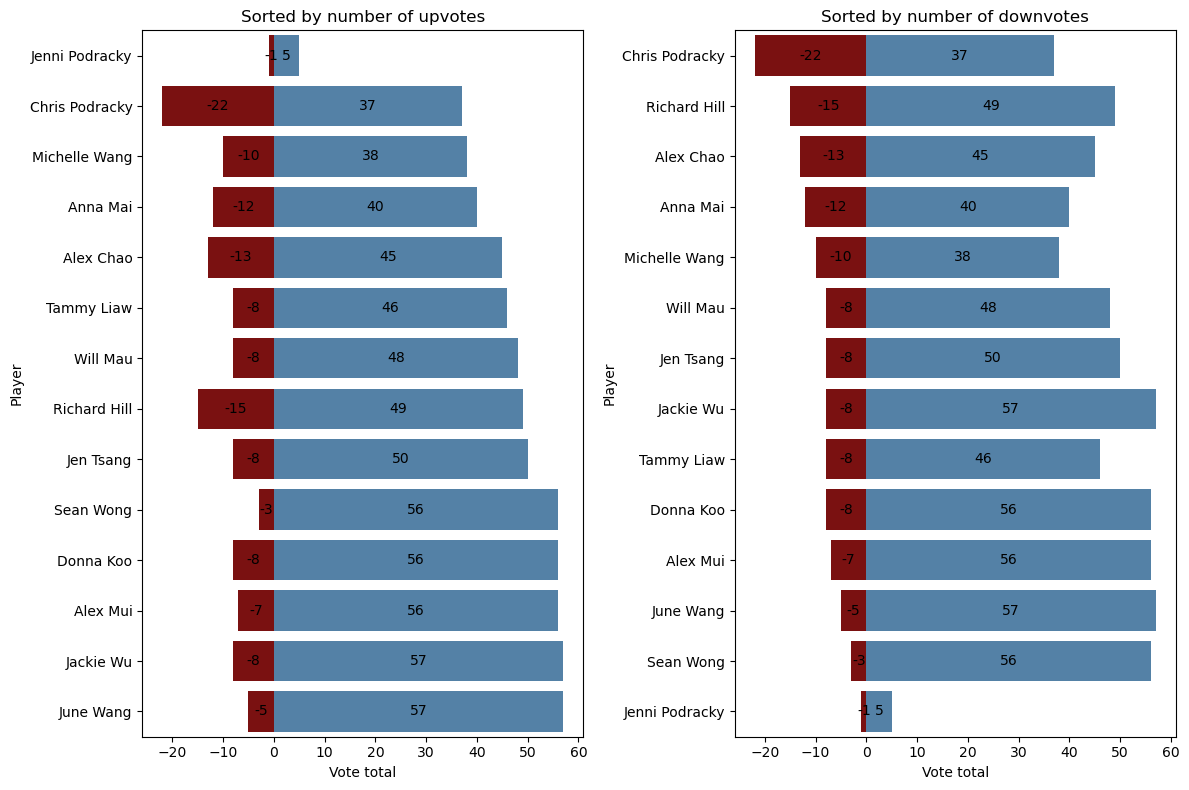

In [14]:
split_votes = (
    edgelist.groupby(["submitter_name", "vote_sign"])["vote_value"]
    .sum()
    .sort_values()
    .reset_index()
)
vote_color = {"upvote": "steelblue", "downvote": "darkred"}

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
for order, ax in zip(vote_color.keys(), axs.flat):
    for side, color in vote_color.items():
        sns.barplot(
            data=split_votes.query("vote_sign == @side"),
            x="vote_value",
            y="submitter_name",
            order=split_votes.query("vote_sign==@order")["submitter_name"],
            color=color,
            ax=ax,
        )
    ax.set_xlabel("Vote total")
    ax.set_ylabel("Player")
    ax.set_title(f"Sorted by number of {order}s")
    ax.bar_label(ax.containers[0], label_type="center")
    ax.bar_label(ax.containers[1], label_type="center")

fig.tight_layout()

## Part II. Artist popularity
I love Music League because it exposes me to amazing artists I've never listened to. My objective for every round has been to share music that I enjoy and others may not have heard before. So personally, I was interested in who was submitting the most indie versus the most basic songs, and whether that affected their performance in the league. To do this, I leveraged Spotify's [artist popularity](https://developer.spotify.com/documentation/web-api/reference/get-an-artist) metric to enrich the submission data. 

*Note that Spotify also has a [track-level popularity metric](https://developer.spotify.com/documentation/web-api/reference/get-an-artists-top-tracks) (i.e., the popularity of each track rather than each artist). Because search results for tracks can turn up multiple results from songs with the same name from different artists, I was too lazy to get the correct popularity value to match with the correct song. Sue me. 

First, I wanted to verify the [face validity](https://en.wikipedia.org/wiki/Face_validity) of Spotify's artist popularity metric. The distribution seems to be more or less normal with a left tail (lower popularity scores), and when I break down the popularity by round number, I found that the low popularity scores are on rounds 2 and 8, which correspond to the Disney and Awesome Obscurity rounds. Awesome Obscurity having the lowest artist popularity makes a lot of sense. Disney also saw a drop, probably because most people probably don't listen to Disney soundtracks as much as they listen to pop artists for example. 

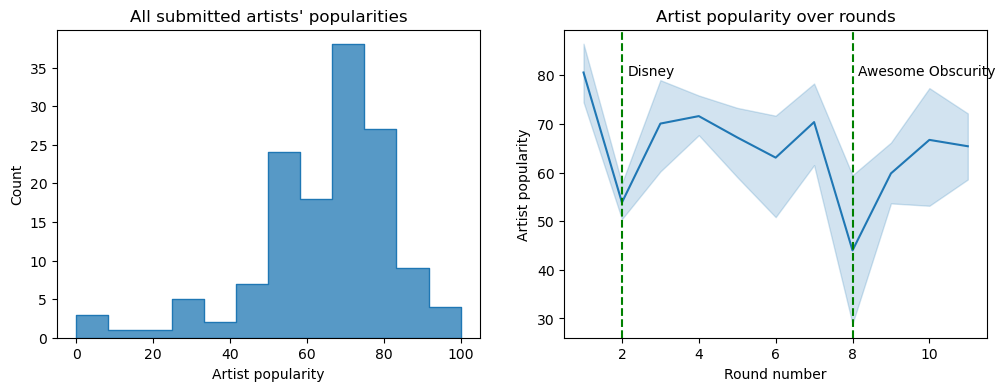

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=submissions, x="artist_popularity", element="step", ax=axs[0])
axs[0].set_xlabel("Artist popularity")
axs[0].set_title("All submitted artists' popularities")

sns.lineplot(data=submissions, x="round_number", y="artist_popularity", ax=axs[1])
for round_number in [2, 8]:
    axs[1].axvline(x=round_number, color="green", linestyle="--")
    axs[1].annotate(
        rounds.query("round_number == @round_number")["round_name"].values[0],
        xy=(round_number, 80),
        xytext=(4, 0),
        textcoords="offset points",
    )

axs[1].set_xlabel("Round number")
axs[1].set_ylabel("Artist popularity")
_ = axs[1].set_title("Artist popularity over rounds")

### Popularity of artists you submitted
Next I wanted to characterize the popularity profiles of artists based on submissions. Who submitted the least and most popular artists? Below shows the distributions of artist popularities for each player's submissions, ranked by the average popularity across all rounds. Red dots indicate the artist popularity for the Awesome Obscurity submission. Some insights:
- **Sean** is the most indie submitter with an average artist popularity of 55.1 for his submissions.
- **Michelle** is the most poppy submitter with an average artist popularity of 77.3 for her submissions.
- **Anna's** submission for the Awesome Obscurity round was her most popular artist out of all her submissions.
- Applause to **Alex Chao** and **Chris** for their submissions that round which achieved artist popularities of 0. 

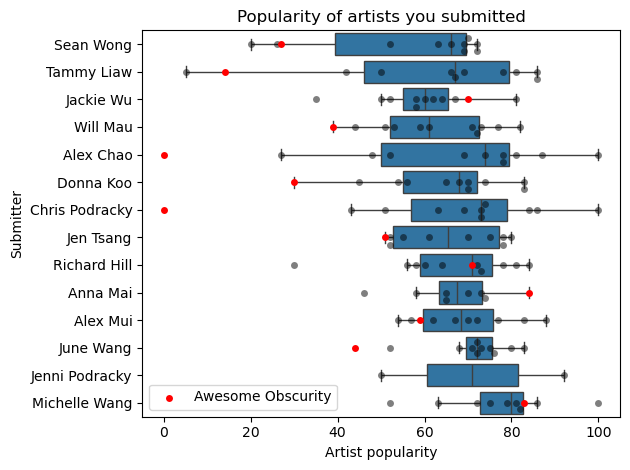

In [16]:
# Get mean artist popularity for each submitter.
popularity_by_submitter = (
    (submissions.groupby("submitter_name")["artist_popularity"].mean().sort_values())
    .reset_index()
    .rename(
        columns={
            "artist_popularity": "submitted_artist_popularity",
            "submitter_name": "player",
        }
    )
)

fig, ax = plt.subplots()
plot_params = {
    "x": "artist_popularity",
    "y": "submitter_name",
    "order": popularity_by_submitter["player"],
    "ax": ax,
}

sns.boxplot(
    **plot_params,
    data=submissions,
    showfliers=False,
)
sns.swarmplot(  # Plot individual data points from every round except Awesome Obscurity
    **plot_params,
    data=submissions.query("round_number != 8"),
    color="k",
    alpha=0.5,
)
round8 = sns.swarmplot(  # Plot Awesome Obscurity
    **plot_params,
    data=submissions.query("round_number == 8"),
    color="red",
    label="Awesome Obscurity",
)

ax.set_xlabel("Artist popularity")
ax.set_ylabel("Submitter")
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[-1]], [labels[-1]])
ax.set_title("Popularity of artists you submitted")
fig.tight_layout()

### Popularity of artists you voted for
On the flip side, we can also look at the popularity of artists you voted for. Though this data is constrained by the popularity of the voting options, and I'm not entirely sure what its utility is, it's still being shown here for completeness. Some insights:
- **Will** is the biggest indie lover -- the average popularity of his voted artists is 60.4.
- **Jen** is the biggest pop lover -- the average popularity of her voted artists is 70.8. 

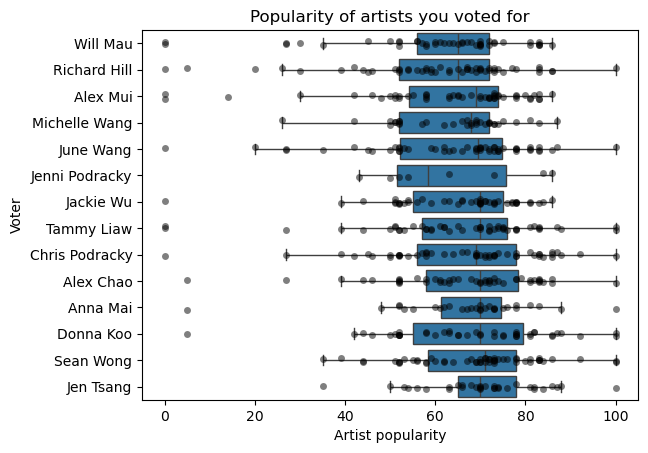

In [35]:
popularity_by_voter = (
    (
        results.query("vote_value > 0")
        .groupby("voter_name")
        .apply(lambda x: np.average(x["artist_popularity"], weights=x["vote_value"]))
        .sort_values()
    )
    .reset_index()
    .rename(columns={0: "voted_artist_popularity", "voter_name": "player"})
)

fig, ax = plt.subplots()
plot_params = {
    "data": results.query("vote_value > 0"),
    "x": "artist_popularity",
    "y": "voter_name",
    "order": popularity_by_voter["player"],
    "ax": ax,
}

sns.boxplot(**plot_params, showfliers=False)
sns.stripplot(
    **plot_params,
    color="k",
    alpha=0.5,
)

ax.set_xlabel("Artist popularity")
ax.set_ylabel("Voter")
_ = ax.set_title("Popularity of artists you voted for")

### Submitted artist popularity vs. final score
Is there a relationship between how well you do and how popular your submissions are? Shown below is the correlation between these two variables. There is a negative relationship where players with more popular submissions ended up with lower scores, but this relationship was not statistically significant (Spearman R=-0.34, p=0.249), so it does not look like the popularity of your submissions affect your standing. 

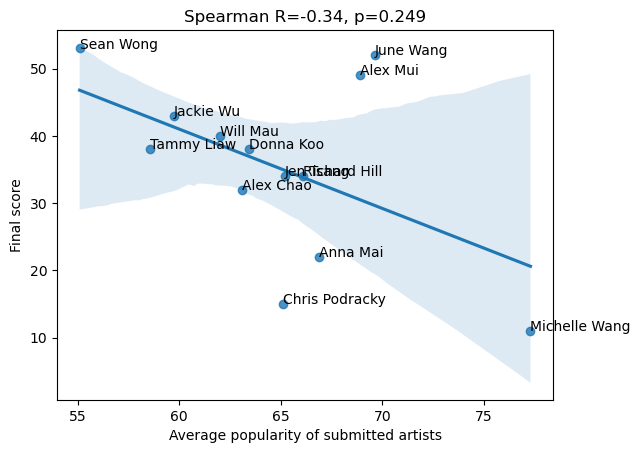

In [34]:
score_to_popularity = (
    final_score.sort_values("points", ascending=False)
    .reset_index()
    .rename(columns={"submitter_name": "player"})
    .merge(popularity_by_submitter, on="player", how="inner")
)
score_to_popularity = score_to_popularity.loc[
    score_to_popularity["player"] != "Jenni Podracky"
]

r, pvalue = scipy.stats.spearmanr(
    score_to_popularity["submitted_artist_popularity"], score_to_popularity["points"]
)

fig, ax = plt.subplots()

for i, row in score_to_popularity.iterrows():
    ax.annotate(row["player"], (row["submitted_artist_popularity"], row["points"]))
sns.regplot(
    data=score_to_popularity, x="submitted_artist_popularity", y="points", ax=ax
)
ax.set_title(f"Spearman R={round(r, 2)}, p={round(pvalue,3)}")
ax.set_xlabel("Average popularity of submitted artists")
_ = ax.set_ylabel("Final score")

## Part III. Player relationships
Now we get to, in my opinion, the funnest insights -- the social network of voting patterns. By aggregating the total values of upvotes and downvotes for each pair of players, we can investigate the overall preferences of each player and identify similarities in preference profiles between everyone. This is a fancy way of saying: We can see who likes whose songs and who else has similar preferences. 

### Upvote clustering
Let's start with upvotes. Below is a heatmap of upvotes. The brightness of each square corresponds to the total upvote value that the voter (on the y-axis) gave the submitter (on the x-axis). 
- To see your "favorite" submitter, find your name on the right then move _across_ the matrix to find the brightest square. For example, **Will's** favorite submitter was **Jackie** and **Sean's** favorite submitter was **June** (more on this later).
- To see who your biggest fans were, find your name on the bottom then move _up_ the matrix to the find the brightest square.

On the left is a dendrogram created using [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) which is a fancy method for identifying groups of similar items (in this case, player voting patterns). To read these dendrograms, think of them like evolutionary trees. Your closest "relative" is the one connected by the most immediate branch. For example, the dendrogram suggests that **Alex** and **Donna** have similar tastes (at least based on their voting patterns). Their next closest relative is **Chris** then **June**. **Will** has the most unique taste out of everyone because he is in his own clade (branch). 

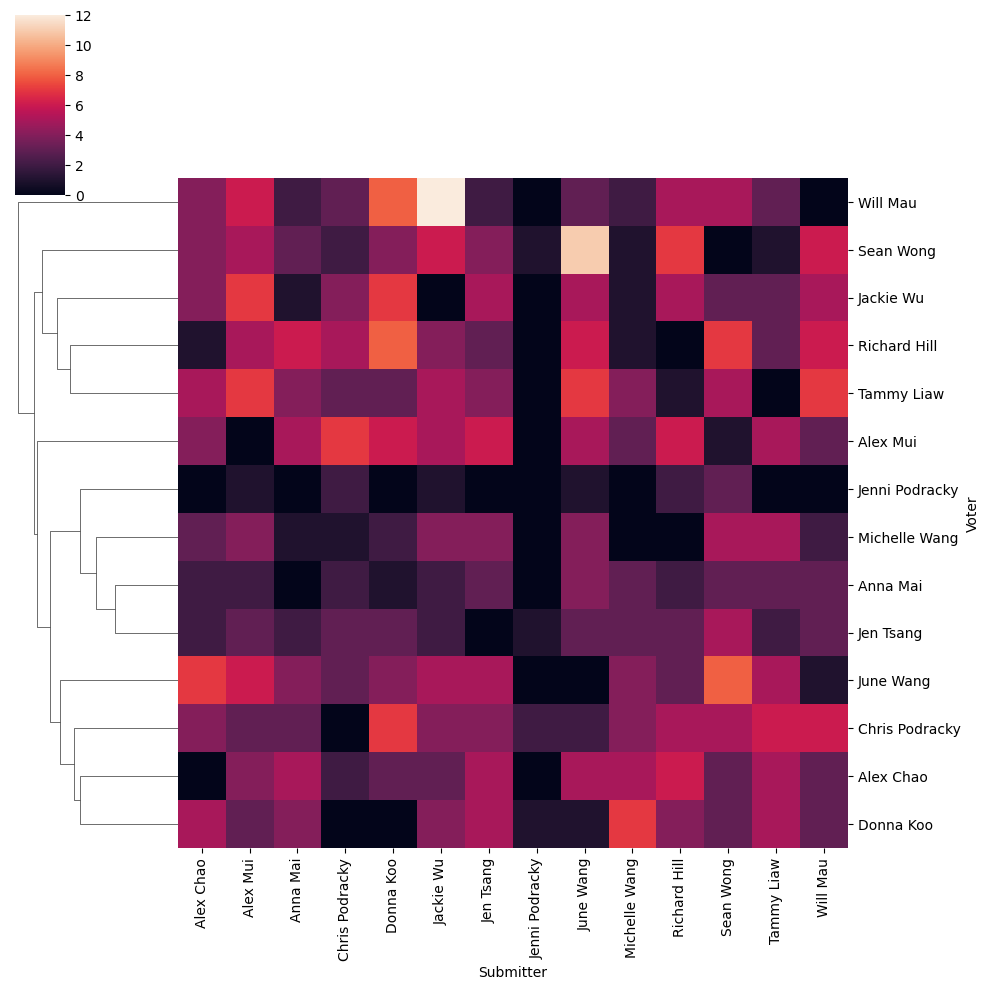

In [33]:
upvote_heatmap = pd.crosstab(
    upvotes["voter_name"],
    upvotes["submitter_name"],
    upvotes["vote_value"],
    aggfunc="sum",
).fillna(0)

c = sns.clustermap(data=upvote_heatmap, col_cluster=False)
ax = c.figure.axes[-2]
ax.set_xlabel("Submitter")
_ = ax.set_ylabel("Voter")

### Downvote clustering
We can employ basically the identical analysis for downvotes to identify similarities in music distaste. 
- Here, **Chris** has the most unique distaste compared to everyone else.
- Also note **Donna's** extreme distaste of **Chris**, the brightest square on this heatmap (more on this later). 

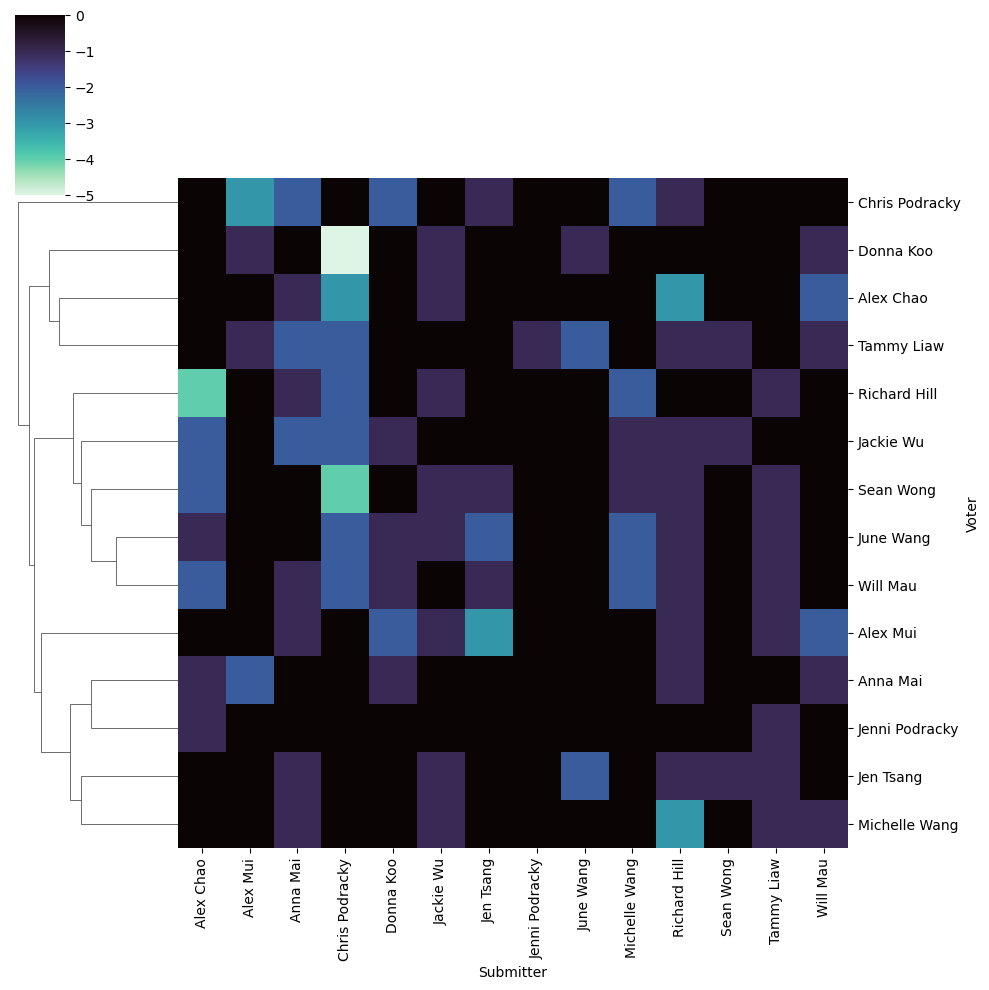

In [32]:
downvote_heatmap = pd.crosstab(
    downvotes["voter_name"],
    downvotes["submitter_name"],
    downvotes["vote_value"],
    aggfunc="sum",
).fillna(0)

c = sns.clustermap(data=downvote_heatmap, col_cluster=False, cmap="mako_r")
ax = c.figure.axes[-2]
ax.set_xlabel("Submitter")
_ = ax.set_ylabel("Voter")

### Graphing player relationships
Next, we can adopt a [network science](https://en.wikipedia.org/wiki/Network_science) approach, which is pretty similar to the approach above but grants visualization techniques that might yield additional insights. Under this framework, each player is a _node_ that connect to each other through _edges_. Specifically, we will construct what's called [MultiDiGraph](https://networkx.org/documentation/stable/reference/classes/multidigraph.html) using the [networkx](https://networkx.org/documentation/stable/index.html) package. A MultiDiGraph is essential a Graph that has _Multiple_ edges and is _Directed_.
- Multiple edges because one edge type corresponds to upvotes and the other edge type corresponds to downvotes.
- Directed because the the edge has directionality -- an upvote is applied from voter to submitter, but not necessarily vice versa. 

In [21]:
G = nx.from_pandas_edgelist(
    edgelist,
    "voter_name_pretty",
    "submitter_name_pretty",
    edge_attr="vote_value",
    create_using=nx.MultiDiGraph,
    edge_key="vote_sign",
)

### Plot whole graph
We'll begin this approach by visualizing the whole graph below. It's pretty overwhelming so let's break it down. 

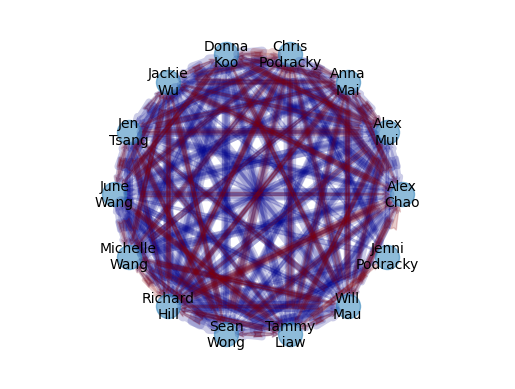

In [31]:
pos = nx.circular_layout(G)
edges = G.edges(data="vote_value", keys=True)
edge_label_bbox = {"alpha": 0, "pad": 0}
edge_params = {
    "G": G,
    "pos": pos,
    "min_source_margin": 20,
    "min_target_margin": 0,
    "alpha": 0.2,
    "arrowstyle": "fancy",
}
edge_colors = {"upvote": "darkblue", "downvote": "darkred"}
edge_label_params = {"G": G, "pos": pos, "bbox": edge_label_bbox}
edge_label_positions = {"upvote": 0.5, "downvote": 0.75}

fig, ax = plt.subplots()

nx.draw_networkx_nodes(G, pos=pos, ax=ax, alpha=0.5, margins=0.1)
nx.draw_networkx_labels(G, pos=pos, font_size=10, ax=ax)

for vote_type, color in edge_colors.items():
    _ = nx.draw_networkx_edges(
        **edge_params,
        edgelist=[(i, j) for i, j, key in G.edges(keys=True) if key == vote_type],
        width=[value for i, j, key, value in edges if key == vote_type],
        ax=ax,
        edge_color=color,
    )

ax.axis("equal")
_ = ax.axis("off")

### Who do I vote for?
Instead of plotting the entire graph, let's focus on one player at a time and plot their "outgoing" edges (i.e., their votes). Each subplot below shows those outgoing edges. You can find yours and study how you tended to vote, whether you tended to upvote or downvote specific individuals' submissions, or whether it was evenly distributed.

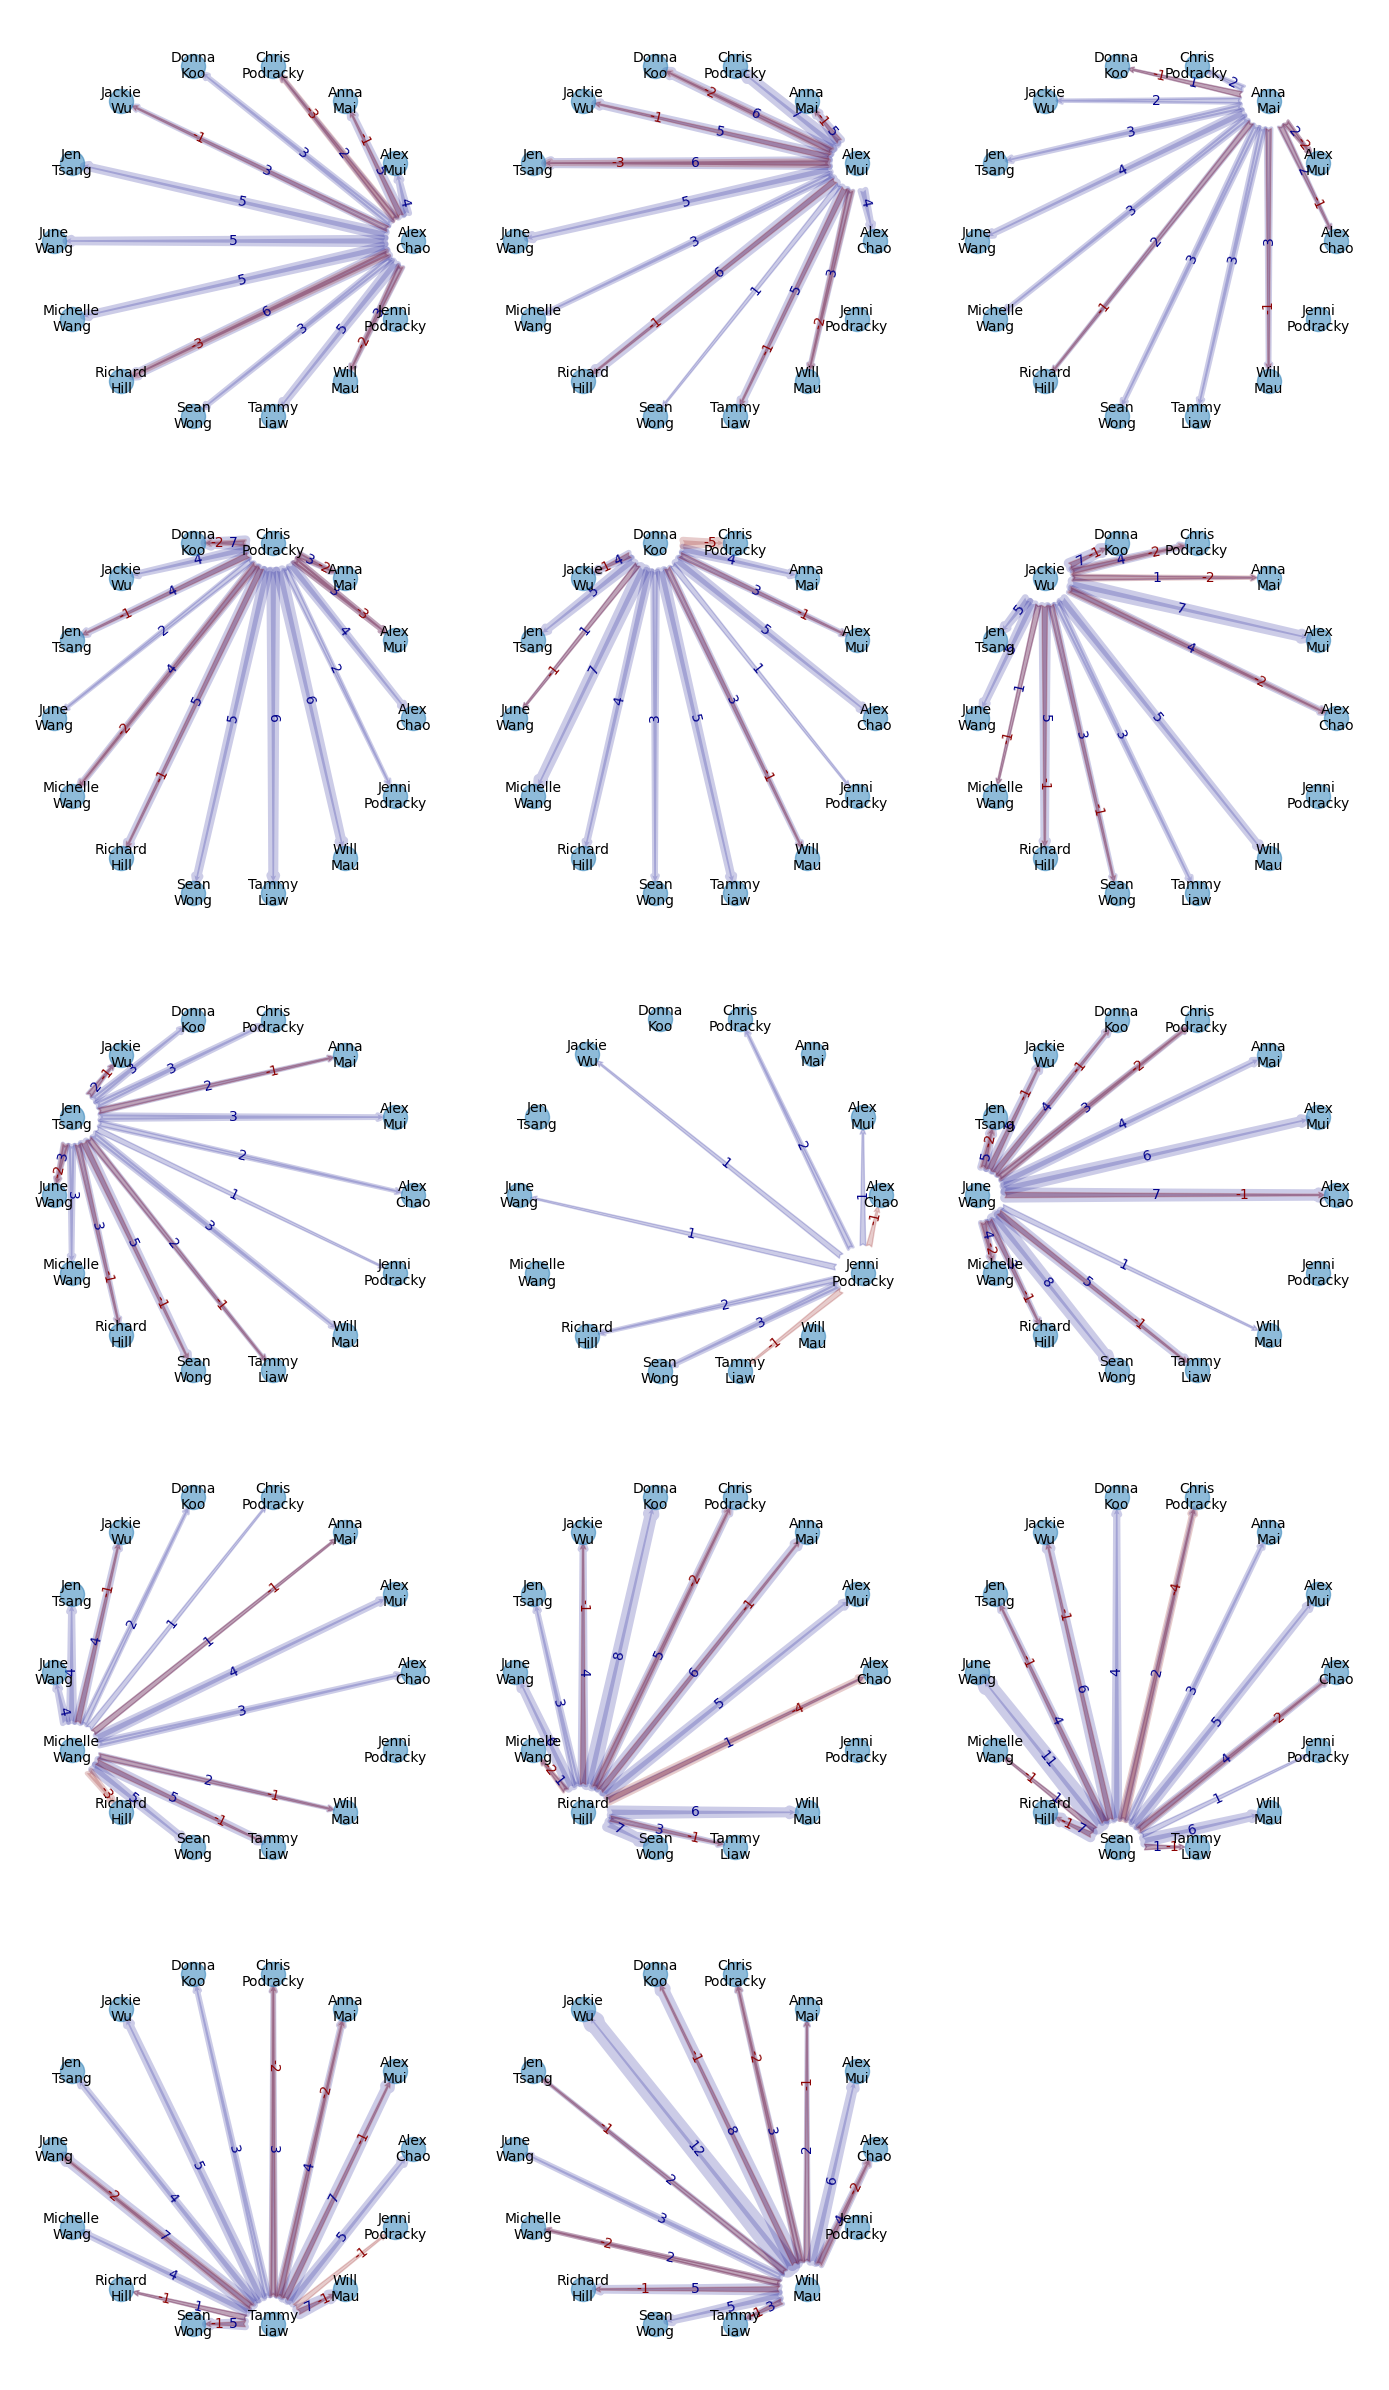

In [23]:
fig, axs = plt.subplots(5, 3, figsize=(14, 24))

for voter, ax in zip(edgelist["voter_name_pretty"].unique(), axs.flat):
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, alpha=0.5, margins=0.1)
    nx.draw_networkx_labels(G, pos=pos, font_size=10, ax=ax)

    for vote_type, color in edge_colors.items():
        _ = nx.draw_networkx_edges(
            **edge_params,
            edgelist=[
                (i, j) for i, j, key, value in edges if key == vote_type and i == voter
            ],
            width=[
                value for i, j, key, value in edges if key == vote_type and i == voter
            ],
            edge_color=color,
            ax=ax,
        )

    for vote_type, color in edge_colors.items():
        _ = nx.draw_networkx_edge_labels(
            **edge_label_params,
            edge_labels={
                (i, j): value
                for i, j, key, value in edges
                if i == voter and key == vote_type
            },
            label_pos=edge_label_positions[vote_type],
            font_color=color,
            ax=ax,
        )

    ax.axis("equal")
    ax.axis("off")
axs.flat[-1].axis("off")
fig.tight_layout()

### Who votes for me?
Conversely, we can also examine _incoming_ edges (i.e., who votes for you). There are a number of insights here that are more apparent than in the previous visualization:
- In a previous analysis, we found that **Chris's** submissions were the most unpopular, but here we get the additional insight that his submissions are pretty much universally disliked by most players. Only 4 out of 13 players never downvoted you.
- **Donna** in particular absolutely abhors **Chris's** submissions, as demonstrated by her -5 downvotes and 0 upvotes for him.
- The women in couples (**Jackie**, **June**, and **Donna**) whose partners are also in the league had the highest number of upvotes from those partners. **Will** gave **Jackie** 12 upvotes, **Sean** gave **June** 11 upvotes, and **Richard** gave **Donna** 8 upvotes.
- However, this "collusion" was not reciprocated. **Jackie** only gave **Will** 5 upvotes (vs. 12), **June** gave **Sean** 8 upvotes (vs. 11), and **Donna** gave **Richard** 4 upvotes (vs. 8). Therefore, the men are simps. 

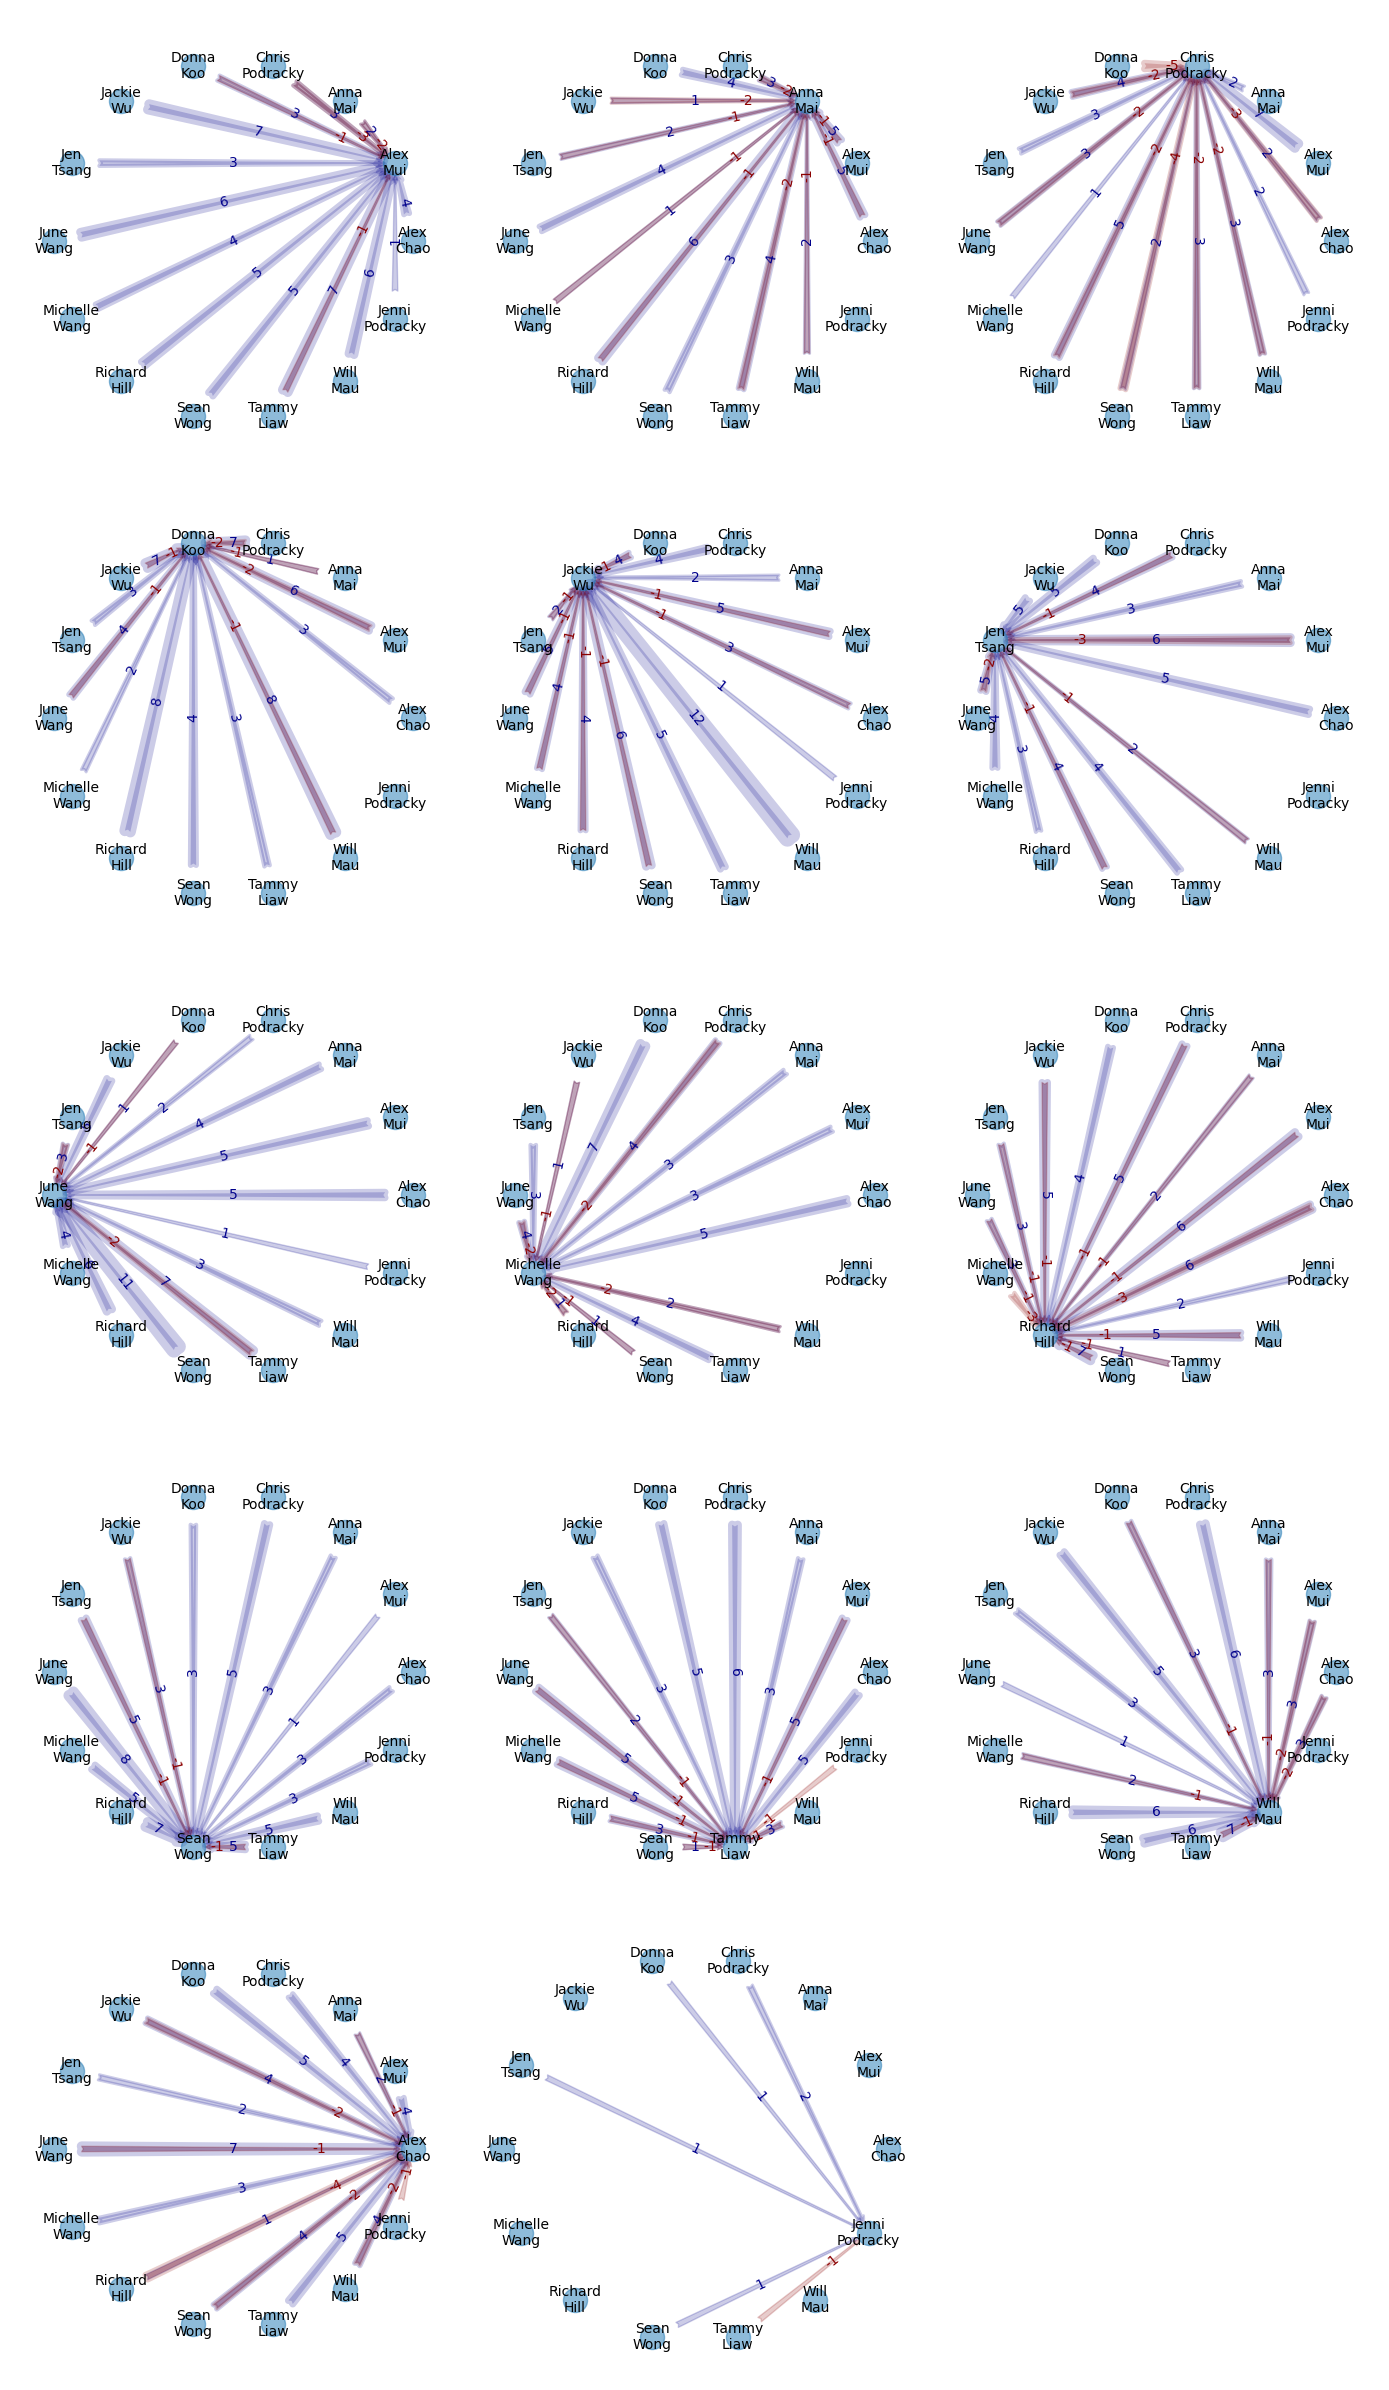

In [24]:
fig, axs = plt.subplots(5, 3, figsize=(14, 24))

for submitter, ax in zip(edgelist["submitter_name_pretty"].unique(), axs.flat):
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, alpha=0.5, margins=0.1)
    nx.draw_networkx_labels(G, pos=pos, font_size=10, ax=ax)

    for vote_type, color in edge_colors.items():
        _ = nx.draw_networkx_edges(
            **edge_params,
            edgelist=[
                (i, j)
                for i, j, key, value in edges
                if key == vote_type and j == submitter
            ],
            width=[
                value
                for i, j, key, value in edges
                if key == vote_type and j == submitter
            ],
            edge_color=color,
            ax=ax,
        )

    for vote_type, color in edge_colors.items():
        _ = nx.draw_networkx_edge_labels(
            **edge_label_params,
            edge_labels={
                (i, j): value
                for i, j, key, value in edges
                if j == submitter and key == vote_type
            },
            label_pos=edge_label_positions[vote_type],
            font_color=color,
            ax=ax,
        )

    ax.axis("equal")
    ax.axis("off")
axs.flat[-1].axis("off")
fig.tight_layout()

### Colluding couples?
As mentioned above, it appears as though couples vote for their partners more often than they vote for other people. Is this a coincidence or a real effect? I tested this statistically by grouping the vote values for couples and non-couples. There was indeed a significant statistical difference between couples and non-couples (Mann-Whitney U test p<0.0005). There are a few possible explanations for this finding:
1. Couples are colluding and voting for each other (albeit unidirectionally so the men get less benefit).
2. Similar music tastes attracted them together in the first place (the opposite causality direction).
3. The [mere exposure effect](https://en.wikipedia.org/wiki/Mere-exposure_effect) from having heard a submitted song in passing (or often) in their communal spaces increased their positive attitude towards those songs.

Either way, lols

In [25]:
temp = [
    ("Jackie Wu", "Will Mau"),
    ("Donna Koo", "Richard Hill"),
    ("June Wang", "Sean Wong"),
]
couples = temp.copy()
for f, m in temp:
    couples.append((m, f))
couples_df = pd.DataFrame(couples, columns=["voter_name", "submitter_name"])
couples_df["couple_status"] = "couple"

couple_edges = edgelist.merge(
    couples_df, on=["voter_name", "submitter_name"], how="left"
).fillna("non-couple")

couple_edges = (
    couple_edges.groupby(["voter_name", "submitter_name", "couple_status"])[
        "vote_value"
    ]
    .sum()
    .reset_index()
)

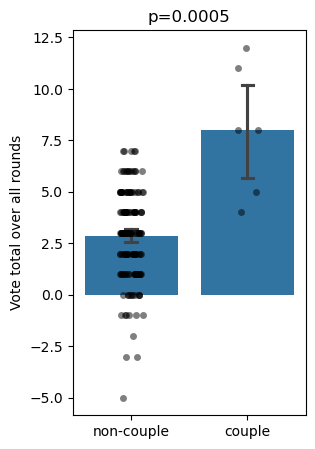

In [30]:
pvalue = scipy.stats.mannwhitneyu(
    couple_edges.query("couple_status == 'couple'")["vote_value"],
    couple_edges.query("couple_status == 'non-couple'")["vote_value"],
).pvalue

fig, ax = plt.subplots(figsize=(3, 5))

sns.barplot(data=couple_edges, x="couple_status", y="vote_value", capsize=0.1, ax=ax)
sns.stripplot(
    data=couple_edges, x="couple_status", y="vote_value", color="k", alpha=0.5, ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("Vote total over all rounds")
_ = ax.set_title(f"p={round(pvalue,4)}")

# Appendix
Below are random other things that I looked at but didn't include in the main body. 

## Common genres

In [27]:
submissions.groupby(["submitter_name", "primary_genre"])[
    "round_number"
].count().reset_index().rename(columns={"round_number": "count"}).sort_values(
    ["submitter_name", "count"], ascending=False
).groupby(
    "submitter_name"
).first().sort_values(
    "count", ascending=False
)

,primary_genre,count
submitter_name,,
Michelle Wang,'pop',4
Tammy Liaw,'dance pop',3
Alex Chao,'pop',2
Alex Mui,'art pop',2
Chris Podracky,'alternative metal',2
Donna Koo,'c-pop',2
Jackie Wu,'k-pop',2
Jen Tsang,'dance pop',2
June Wang,'neo soul',2


### Popularity of submitted vs. voted artists
The plot below shows the relationship between your voting preferences and your submitting preferences with respect to artist popularity. Players below the dotted line tend to vote for less popular artists than they submit and players above the line vice versa. 

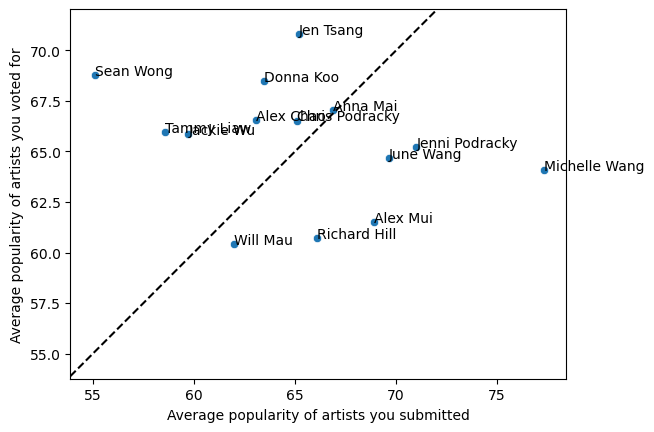

In [42]:
popularity_corr = popularity_by_voter.merge(
    popularity_by_submitter, how="inner", on="player"
)

fig, ax = plt.subplots()
sns.scatterplot(
    data=popularity_corr,
    x="submitted_artist_popularity",
    y="voted_artist_popularity",
    ax=ax,
)
for _, row in popularity_corr.iterrows():
    ax.annotate(
        row["player"],
        (row["submitted_artist_popularity"], row["voted_artist_popularity"]),
    )

ax.axline((55, 55), slope=1, linestyle="--", color="k")
ax.set_xlabel("Average popularity of artists you submitted")
ax.set_ylabel("Average popularity of artists you voted for")
_ = ax.axis("equal")